## Generative Setting (CWGAN-GP)

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns
from tensorflow.keras.layers import Dense, concatenate, Input
from sklearn.utils import shuffle

from scipy.stats import wasserstein_distance
from skimage.metrics import structural_similarity as ssim

import scipy
from scipy.stats import wasserstein_distance
from skimage.metrics import structural_similarity as ssim
from sklearn.preprocessing import MinMaxScaler

# define model architecture : 1DCNN-classification
from keras.layers import Input,concatenate
from keras.models import Model, Sequential

#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Input
from keras.models import Model

"input"="condition": label1, label2, label3, label4, label5, label6, label
"output"="target": d1,d2,d3,d4,d5,d6,F,t

In [2]:
## All variables ##

j = 1                  #trial number
epoch_num = 8          # total epoch to run
BATCH_SIZE = 100       # batch size of train set
noise_dim = 25         # dimension of noise vector for generator
condition_dim = 6      # dimension of condition vector for generator
gen_dim = 8            # dimension of generator's output vector
D_cycle = 5            # train disctriminator "D_cycle" times in one epoch, number of critic iterations per epoch
steps_show = 1         # update figure per "steps_show" epoches

In [1]:
dataframe=pd.read_csv('data.csv')
dataframe.head()

NameError: name 'pd' is not defined

In [7]:
dataframe = shuffle(dataframe)

In [3]:
inp = dataframe[['label1','label2','label3','label4','label5','label6']]

NameError: name 'dataframe' is not defined

In [9]:
inp=np.array(inp, dtype=np.float32)

In [2]:
out = dataframe[['d1','d2', 'd3','d4','d5','d6','F', 't',]]

NameError: name 'dataframe' is not defined

In [11]:
out=np.array(out, dtype=np.float32)

In [12]:
data_real = tf.concat([inp, out], axis=1)

<tf.Tensor: shape=(1200000, 14), dtype=float32, numpy=
array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.4438796e-02,
        3.5696344e+02, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 2.2789951e-02,
        2.3704800e+02, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, ..., 3.4943920e-02,
        3.7554153e+02, 1.8000000e+01],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 2.3034366e-02,
        2.4924875e+02, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.5426058e-02,
        3.7952393e+02, 1.5000000e+01],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, ..., 7.0499200e-03,
        7.6702278e+01, 2.7000000e+01]], dtype=float32)>

inp=['label1','label2','label3','label4','label5','label6', 'label']
out=['d1','d2', 'd3','d4','d5','d6','F','t',]
data = tf.concat([inp, out], axis=1) = ['label1','label2','label3','label4','label5','label6', 'label', 'd1','d2', 'd3','d4','d5','d6','F','t']

In [13]:
scaler = MinMaxScaler(feature_range=(0,1))
out_scaled = scaler.fit_transform(out)

## Training

In [14]:
data = tf.concat([inp, out_scaled], axis=1)
train_dataset = tf.data.Dataset.from_tensor_slices(data[:num_first,:]).batch(BATCH_SIZE)

In [15]:
data.shape

TensorShape([1200000, 14])

In [16]:
train_dataset

<BatchDataset element_spec=TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)>

In [17]:
inp_condition = Input(shape=[condition_dim, 1], name='condition_G')
inp_noise = Input(shape=[noise_dim, 1], name='noise')
X = concatenate([inp_condition, inp_noise], axis=1)
X

<KerasTensor: shape=(None, 31, 1) dtype=float32 (created by layer 'concatenate')>

In [18]:
## Generator and Discriminator ##
def Generator():
    inp_condition = Input(shape=[condition_dim,1 ], name='condition_G')
    inp_noise = Input(shape=[noise_dim,1 ], name='noise')
    X = concatenate([inp_condition, inp_noise], axis=1)
    
    X = Conv1D(filters = 32, kernel_size = 3)(X)
    #X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPooling1D(pool_size=2)(X)
    
    X = Conv1D(filters = 32, kernel_size = 3)(X)
    #X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPooling1D(pool_size=2)(X)
         
    X = Conv1D(filters = 32, kernel_size = 2)(X)
    #X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPooling1D(pool_size=2)(X)
    
    X = Flatten()(X)
    
    X = Dense(64, activation='relu')(X)
    #X = BatchNormalization()(X)
    X = Dense(32, activation='relu')(X)
    #X = BatchNormalization()(X)
    
    last = Dense(gen_dim, activation="tanh")(X)
    #last = Dense(gen_dim)(X)
    return tf.keras.Model(inputs=[inp_condition, inp_noise], outputs=last, name='Generator')
    
def Discriminator():
    inp_condition = Input(shape=[condition_dim, 1], name='condition_D')
    inp_target = tf.keras.layers.Input(shape=[gen_dim,1], name='target')
    X = concatenate([inp_condition, inp_target], axis=1)
        
    X = Conv1D(filters = 32, kernel_size = 3)(X)
    #X = BatchNormalization()(X)
    X = Activation('LeakyReLU')(X)
    X = Dropout(0.3)(X)
    
    X = Conv1D(filters = 32, kernel_size = 3)(X)
    #X = BatchNormalization()(X)
    X = Activation('LeakyReLU')(X)
    #X = Dropout(0.3)(X)
           
    X = Conv1D(filters = 32, kernel_size = 2)(X)
    #X = BatchNormalization()(X)
    X = Activation('LeakyReLU')(X)
    #X = Dropout(0.3)(X)
    
    X = Flatten()(X)
        
    last = Dense(1)(X)
    return tf.keras.Model(inputs=[inp_condition, inp_target], outputs=last, name='Discriminator')   

generator = Generator()
discriminator = Discriminator()
generator.summary()
discriminator.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 condition_G (InputLayer)       [(None, 6, 1)]       0           []                               
                                                                                                  
 noise (InputLayer)             [(None, 25, 1)]      0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 31, 1)        0           ['condition_G[0][0]',            
                                                                  'noise[0][0]']                  
                                                                                                  
 conv1d (Conv1D)                (None, 29, 32)       128         ['concatenate_1[0][0]']  

In [19]:
## Generator loss and Discriminator loss ##
lambda_reg = 10  #0.5,  Gradient penalty coefficient (λ)
def discriminator_loss(D_real, D_fake, penalty):
    D_loss = tf.reduce_mean(D_fake - D_real + lambda_reg * penalty)
    return D_loss

def generator_loss(D_fake):
    G_loss = -tf.reduce_mean(D_fake)
    return G_loss

## Optimizers ##
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9) #1e-3, beta_1=0.5, beta_2=0.9
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9)

## Gradient penalty to the Discriminator loss ##
def penalty_calculation(X_real, G_fake, condition):
    # Create the gradient penalty operations.
    epsilon = tf.random.uniform(shape=tf.shape(X_real), minval=0., maxval=1.)  #minval=0., maxval=1.
    interpolation = epsilon * X_real + (1 - epsilon) * G_fake
    with tf.GradientTape() as pena_tape:
        pena_tape.watch(interpolation)
        penalty = (tf.norm(
            pena_tape.gradient(discriminator([condition, interpolation]), interpolation),
            axis=1) - 1) ** 2.0
    return penalty

## Train Generator and Discriminator independently  ##
@tf.function
def train_G(data_batch):
    noise = tf.random.normal([data_batch.shape[0], noise_dim], mean=0.0, stddev=0.1, #stddev=1.0
                             dtype=tf.dtypes.float32)
    condition = data_batch[:, :condition_dim]                                   #OJO condition = data_batch[:, :3]
    with tf.GradientTape() as gen_tape:
        G_fake = generator([condition, noise], training=True)
        D_fake = discriminator([condition, G_fake], training=True)
        G_loss = generator_loss(D_fake)
    gradients_of_generator = gen_tape.gradient(G_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    return G_loss

@tf.function
def train_D(data_batch):
    noise = tf.random.normal([data_batch.shape[0], noise_dim], mean=0.0, stddev=0.1, #stddev=1.0
                             dtype=tf.dtypes.float32)
    condition = data_batch[:, :condition_dim]                                   #OJO condition = data_batch[:, :3]
    target = data_batch[:, condition_dim :condition_dim + gen_dim]                                        #OJO target = data_batch[:, 3:]
    with tf.GradientTape() as disc_tape:
        G_fake = generator([condition, noise], training=True)
        D_real = discriminator([condition, target], training=True)
        D_fake = discriminator([condition, G_fake], training=True)
        penalty = penalty_calculation(target, G_fake, condition)
        D_loss = discriminator_loss(D_real, D_fake, penalty)
    gradients_of_discriminator = disc_tape.gradient(D_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return D_loss


def train(dataset, epochs, D_cycle=D_cycle, steps_show=steps_show):          #D_cycle=1
    #list_limx = [[0, .050], [0, .050], [0, .050], [0, .050]]
    #list_limy = [[0, 100], [0, 450], [-0.1, 1.1], [-0.1, 1.1]]
    start = time.time()
    
    loss_G_train = []
    loss_D_train = []
    for epoch in range(epochs):
        for data_batch in dataset:
            G_loss = train_G(data_batch)
            for _ in range(D_cycle):
                D_loss = train_D(data_batch)

        loss_G_train.append(G_loss.numpy())
        loss_D_train.append(D_loss.numpy())

        num_test = num_first
        condition = data[:num_test, :condition_dim]                        #OJO condition = data[:num_test, :3] 
        noise = tf.random.normal([num_test, noise_dim], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32)  #stddev=1.0
        generated_out = generator([condition, noise], training=True)

        generated_out_final = scaler.inverse_transform(generated_out)


        tiempo = time.time() - start

        minutos = int(tiempo // 60)
        segundos = int(tiempo % 60)

        #print(f"Minutos: {minutos}")
        #print(f"Segundos: {segundos}")
        print('Time for epoch {}/{} is {} sec, {} minutos y {} segundos'.format(epoch, epochs, time.time() - start, minutos, segundos ))

    return loss_G_train, loss_D_train, generated_out_final

In [20]:
loss_G_train, loss_D_train, generated_out_final = train(train_dataset, epochs=epoch_num, D_cycle=D_cycle, steps_show=steps_show)

Time for epoch 0/8 is 526.3204698562622 sec, 8 minutos y 46 segundos
Time for epoch 1/8 is 1078.7744331359863 sec, 17 minutos y 58 segundos
Time for epoch 2/8 is 1675.093605041504 sec, 27 minutos y 55 segundos
Time for epoch 3/8 is 2241.0254204273224 sec, 37 minutos y 21 segundos
Time for epoch 4/8 is 2860.2569630146027 sec, 47 minutos y 40 segundos
Time for epoch 5/8 is 43016.68561959267 sec, 716 minutos y 56 segundos
Time for epoch 6/8 is 43867.55884718895 sec, 731 minutos y 7 segundos
Time for epoch 7/8 is 44744.469072818756 sec, 745 minutos y 44 segundos


In [21]:
generator.save('Models/cWGAN_'+str(j))
print('Model saved in Models/cWGAN_')

INFO:tensorflow:Assets written to: Models/cWGAN_39\assets


INFO:tensorflow:Assets written to: Models/cWGAN_39\assets


Model saved in Models/cWGAN_


In [22]:
num_test = num_first
condition = data[:num_test, :condition_dim]
data_generated = np.concatenate([condition.numpy(), generated_out_final], axis=1)
a=data_generated.shape[0]
a

1200000

In [23]:
dataframe_generated=pd.DataFrame(data_generated)
dataframe_generated

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.0,0.0,0.0,0.0,0.0,0.0,0.004081,0.009004,0.013986,0.019010,0.023331,0.027291,290.760154,0.044705
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000589,0.001331,0.002190,0.002852,0.003154,0.003297,30.154762,1.175977
2,0.0,0.0,1.0,0.0,0.0,0.0,0.001895,0.005388,0.009216,0.014015,0.015967,0.017993,161.215506,46.375002
3,0.0,0.0,0.0,0.0,0.0,0.0,0.003157,0.007192,0.011149,0.015354,0.019042,0.022526,252.929137,1.166607
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000243,0.000659,0.000349,0.000545,0.000742,0.000819,12.269107,0.109898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,0.0,0.0,0.0,0.0,0.0,1.0,0.002416,0.007470,0.012884,0.020118,0.024678,0.028994,256.179218,91.677811
1199996,0.0,0.0,1.0,0.0,0.0,0.0,0.001282,0.003639,0.006363,0.010315,0.011163,0.012198,94.296133,52.726634
1199997,0.0,0.0,0.0,0.0,0.0,0.0,0.004170,0.009136,0.014405,0.019810,0.024039,0.028214,299.288494,2.320253
1199998,0.0,0.0,0.0,0.0,0.0,1.0,0.001767,0.006483,0.011977,0.019484,0.023658,0.027638,235.751288,93.435570


In [24]:
filtro = (dataframe_generated.iloc[:, 7] >= 0) & (dataframe_generated.iloc[:, 8] >= 0) & (dataframe_generated.iloc[:, 9] >= 0) & (dataframe_generated.iloc[:, 10] >= 0) & (dataframe_generated.iloc[:, 11] >= 0) & (dataframe_generated.iloc[:, 12] >= 0) & (dataframe_generated.iloc[:, 13] >= 0) & (dataframe_generated.iloc[:, 14] >= 0)
dataframe_generated_filtrado = dataframe_generated[filtro]
b=dataframe_generated_filtrado.shape[0]
b

IndexError: single positional indexer is out-of-bounds

In [ ]:
a-b

In [ ]:
(a-b)*100/a

In [ ]:
dataframe_generated = dataframe_generated_filtrado

IndexError: index 14 is out of bounds for axis 1 with size 14

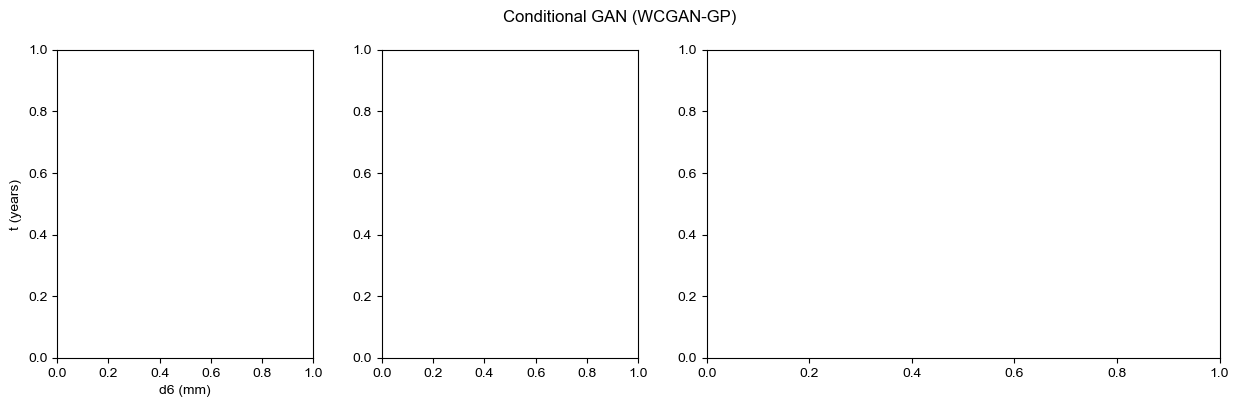

In [25]:
num_test = num_first
condition = data[:num_test, :condition_dim]                        #OJO condition = data[:num_test, :3] 

# Crear una figura con 1 fila y 3 columnas
figure = plt.figure(figsize=(15, 4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 2])

# Subplots con tamaños personalizados
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

figure.suptitle("Conditional GAN (WCGAN-GP)")
sns.set(color_codes=True, style='white', palette='colorblind')
          
### d6 - t  ###
ax0.set_xlabel('d6 (mm)')
ax0.set_ylabel('t (years)')          
plot_data_real = data_real.numpy()[:num_test, :]                      
ax0.plot(plot_data_real[:num_test, 12], plot_data_real[:num_test, 14], '.b', alpha=.5, label="Real")
plot_data_generated = dataframe_generated.values
ax0.plot(plot_data_generated[:num_test, 12], plot_data_generated[:num_test, 14], '.r', alpha=.05, label="Generated")
ax0.legend(loc='lower right')  #ojo                               
            
###  d6 - F  ###
ax1.set_xlabel('d6 (mm)')
ax1.set_ylabel('F (N)')          
plot_data_real  = data_real.numpy()[:num_test, :]
ax1.plot(plot_data_real [:num_test, 12], plot_data_real [:num_test, 13], '.b', alpha=.5, label="Real")
plot_data_generated = dataframe_generated.values
ax1.plot(plot_data_generated[:num_test, 12], plot_data_generated[:num_test, 13], '.r', alpha=.05, label="Generated")
ax1.legend(loc='lower right')         
  
### Figure Loss-Epochs ###
ax2.plot([-i for i in loss_G_train], '-', label="Gen loss")        #ojo
ax2.plot([-i for i in loss_D_train], '-', label="Crit loss")   #ojo
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.legend()  #ojo

figure.show()

#figure.savefig('cWGAN_j.png')
#print('Figure saved in cWGAN.png')

In [ ]:
num_test = num_first
condition = data[:num_test, :condition_dim]                        #OJO condition = data[:num_test, :3] 
           
fontsize = 8
    
list_limx = [[0, .055], [0, .055], [0, .055], [0, .055], [0, .055], [0, .055], [0, .055]]
#list_limy = [[0, 100], [0, 450], [-0.1, 1.1], [-0.1, 1.1]]
figure, ax = plt.subplots(1, 7, figsize=(15, 3))
figure.suptitle("Conditional GAN (WCGAN-GP)")
sns.set(color_codes=True, style='white', palette='colorblind')
          
### d1  -  label1  ###
i = 0
ax[i].clear()
ax[i].set_xlim(list_limx[i])
#ax[i].set_ylim(list_limy[i])
ax[i].set_xlabel('d1 (mm)')
ax[i].set_ylabel('label1')
plot_data_real= data_real.numpy()[:num_test, :]                
ax[i].plot(plot_data_real[:num_test, 7], plot_data_real[:num_test, 0], '.b', alpha=.5, label="Real")
ax[i].yaxis.set_major_locator(plt.MultipleLocator(base=1)) #ojo
ax[i].yaxis.set_major_formatter('{:.0f}'.format)  #ojo
plot_data_generated = dataframe_generated.values
ax[i].plot(plot_data_generated[:num_test, 7], plot_data_generated[:num_test, 0]+0.05, '.r', alpha=.5, label="Generated")
ax[i].legend(loc='center right', fontsize=fontsize)
plt.subplots_adjust(wspace=0.5)  #ojo 
                                
### d2  -  label2  ###
i = 1
ax[i].clear()
ax[i].set_xlim(list_limx[i])
#ax[i].set_ylim(list_limy[i])
ax[i].set_xlabel('d2 (mm)')
ax[i].set_ylabel('label2')
plot_data_real= data_real.numpy()[:num_test, :]                
ax[i].plot(plot_data_real[:num_test, 8], plot_data_real[:num_test, 1], '.b', alpha=.5, label="Real")
ax[i].yaxis.set_major_locator(plt.MultipleLocator(base=1)) #ojo
ax[i].yaxis.set_major_formatter('{:.0f}'.format)  #ojo
plot_data_generated = dataframe_generated.values
ax[i].plot(plot_data_generated[:num_test, 8], plot_data_generated[:num_test, 1]+0.05, '.r', alpha=.5, label="Generated")
ax[i].legend(loc='center right', fontsize=fontsize)
plt.subplots_adjust(wspace=0.5)  #ojo   

### d3  -  label3  ###
i = 2
ax[i].clear()
ax[i].set_xlim(list_limx[i])
#ax[i].set_ylim(list_limy[i])
ax[i].set_xlabel('d3 (mm)')
ax[i].set_ylabel('label3')
plot_data_real= data_real.numpy()[:num_test, :]                
ax[i].plot(plot_data_real[:num_test, 9], plot_data_real[:num_test, 2], '.b', alpha=.5, label="Real")
ax[i].yaxis.set_major_locator(plt.MultipleLocator(base=1)) #ojo
ax[i].yaxis.set_major_formatter('{:.0f}'.format)  #ojo
plot_data_generated = dataframe_generated.values
ax[i].plot(plot_data_generated[:num_test, 9], plot_data_generated[:num_test, 2]+0.05, '.r', alpha=.5, label="Generated")
ax[i].legend(loc='center right', fontsize=fontsize)
plt.subplots_adjust(wspace=0.5)  #ojo   

### d4  -  label4  ###
i = 3
ax[i].clear()
ax[i].set_xlim(list_limx[i])
#ax[i].set_ylim(list_limy[i])
ax[i].set_xlabel('d4 (mm)')
ax[i].set_ylabel('label4')
plot_data_real= data_real.numpy()[:num_test, :]                
ax[i].plot(plot_data_real[:num_test, 10], plot_data_real[:num_test, 3], '.b', alpha=.5, label="Real")
ax[i].yaxis.set_major_locator(plt.MultipleLocator(base=1)) #ojo
ax[i].yaxis.set_major_formatter('{:.0f}'.format)  #ojo
plot_data_generated = dataframe_generated.values
ax[i].plot(plot_data_generated[:num_test, 10], plot_data_generated[:num_test, 3]+0.05, '.r', alpha=.5, label="Generated")
ax[i].legend(loc='center right', fontsize=fontsize)
plt.subplots_adjust(wspace=0.5)  #ojo 

### d5  -  label5  ###
i = 4
ax[i].clear()
ax[i].set_xlim(list_limx[i])
#ax[i].set_ylim(list_limy[i])
ax[i].set_xlabel('d5 (mm)')
ax[i].set_ylabel('label5')
plot_data_real= data_real.numpy()[:num_test, :]                
ax[i].plot(plot_data_real[:num_test, 11], plot_data_real[:num_test, 4], '.b', alpha=.5, label="Real")
ax[i].yaxis.set_major_locator(plt.MultipleLocator(base=1)) #ojo
ax[i].yaxis.set_major_formatter('{:.0f}'.format)  #ojo
plot_data_generated = dataframe_generated.values
ax[i].plot(plot_data_generated[:num_test, 11], plot_data_generated[:num_test, 4]+0.05, '.r', alpha=.5, label="Generated")
ax[i].legend(loc='center right', fontsize=fontsize)
plt.subplots_adjust(wspace=0.5)  #ojo 

### d6  -  label6  ###
i = 5
ax[i].clear()
ax[i].set_xlim(list_limx[i])
#ax[i].set_ylim(list_limy[i])
ax[i].set_xlabel('d6 (mm)')
ax[i].set_ylabel('label6')
plot_data_real= data_real.numpy()[:num_test, :]                 
ax[i].plot(plot_data_real[:num_test, 12], plot_data_real[:num_test, 5], '.b', alpha=.5, label="Real")
ax[i].yaxis.set_major_locator(plt.MultipleLocator(base=1)) #ojo
ax[i].yaxis.set_major_formatter('{:.0f}'.format)  #ojo
plot_data_generated = dataframe_generated.values
ax[i].plot(plot_data_generated[:num_test, 12], plot_data_generated[:num_test, 5]+0.05, '.r', alpha=.5, label="Generated")
ax[i].legend(loc='center right', fontsize=fontsize)
plt.subplots_adjust(wspace=0.5)  #ojo    
            
### d6 - label ###
i = 6
ax[i].clear()
ax[i].set_xlim(list_limx[i])
#ax[i].set_ylim(list_limy[i])
ax[i].set_xlabel('d6 (mm)')
ax[i].set_ylabel('label')                                    
plot_data_real  = data_real.numpy()[:num_test, :]
ax[i].plot(plot_data_real [:num_test, 12], plot_data_real [:num_test, 6], '.b', alpha=.5, label="Real")
ax[i].yaxis.set_major_locator(plt.MultipleLocator(base=1)) #ojo
ax[i].yaxis.set_major_formatter('{:.0f}'.format)  #ojo
plot_data_generated = dataframe_generated.values
ax[i].plot(plot_data_generated[:num_test, 12], plot_data_generated[:num_test, 6]+0.05, '.r', alpha=.5, label="Generated")
ax[i].legend(loc='center right', fontsize=fontsize)


figure.show()

#figure.savefig('cWGAN_j.png')
#print('Figure saved in cWGAN.png')

In [26]:
dataframe_generated

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.0,0.0,0.0,0.0,0.0,0.0,0.004081,0.009004,0.013986,0.019010,0.023331,0.027291,290.760154,0.044705
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000589,0.001331,0.002190,0.002852,0.003154,0.003297,30.154762,1.175977
2,0.0,0.0,1.0,0.0,0.0,0.0,0.001895,0.005388,0.009216,0.014015,0.015967,0.017993,161.215506,46.375002
3,0.0,0.0,0.0,0.0,0.0,0.0,0.003157,0.007192,0.011149,0.015354,0.019042,0.022526,252.929137,1.166607
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000243,0.000659,0.000349,0.000545,0.000742,0.000819,12.269107,0.109898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,0.0,0.0,0.0,0.0,0.0,1.0,0.002416,0.007470,0.012884,0.020118,0.024678,0.028994,256.179218,91.677811
1199996,0.0,0.0,1.0,0.0,0.0,0.0,0.001282,0.003639,0.006363,0.010315,0.011163,0.012198,94.296133,52.726634
1199997,0.0,0.0,0.0,0.0,0.0,0.0,0.004170,0.009136,0.014405,0.019810,0.024039,0.028214,299.288494,2.320253
1199998,0.0,0.0,0.0,0.0,0.0,1.0,0.001767,0.006483,0.011977,0.019484,0.023658,0.027638,235.751288,93.435570


In [29]:
# Definir una lista con los nuevos nombres de las columnas
nuevos_nombres = ['label1', 'label2', 'label3', 'label4', 'label5', 'label6','d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'F','t']
# Asignar los nuevos nombres a las columnas
dataframe_generated.columns = nuevos_nombres
# Lista de nombres de las columnas que deseas convertir en enteros
columnas_a_convertir = ['label1', 'label2', 'label3', 'label4', 'label5', 'label6']
# Utiliza el método astype para convertir las columnas en enteros
dataframe_generated[columnas_a_convertir] = dataframe_generated[columnas_a_convertir].astype(int)
dataframe_generated

,label1,label2,label3,label4,label5,label6,d1,d2,d3,d4,d5,d6,F,t
0,0,0,0,0,0,0,0.004081,0.009004,0.013986,0.019010,0.023331,0.027291,290.760154,0.044705
1,0,0,0,0,0,0,0.000589,0.001331,0.002190,0.002852,0.003154,0.003297,30.154762,1.175977
2,0,0,1,0,0,0,0.001895,0.005388,0.009216,0.014015,0.015967,0.017993,161.215506,46.375002
3,0,0,0,0,0,0,0.003157,0.007192,0.011149,0.015354,0.019042,0.022526,252.929137,1.166607
4,0,0,0,0,0,0,0.000243,0.000659,0.000349,0.000545,0.000742,0.000819,12.269107,0.109898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,0,0,0,0,0,1,0.002416,0.007470,0.012884,0.020118,0.024678,0.028994,256.179218,91.677811
1199996,0,0,1,0,0,0,0.001282,0.003639,0.006363,0.010315,0.011163,0.012198,94.296133,52.726634
1199997,0,0,0,0,0,0,0.004170,0.009136,0.014405,0.019810,0.024039,0.028214,299.288494,2.320253
1199998,0,0,0,0,0,1,0.001767,0.006483,0.011977,0.019484,0.023658,0.027638,235.751288,93.435570


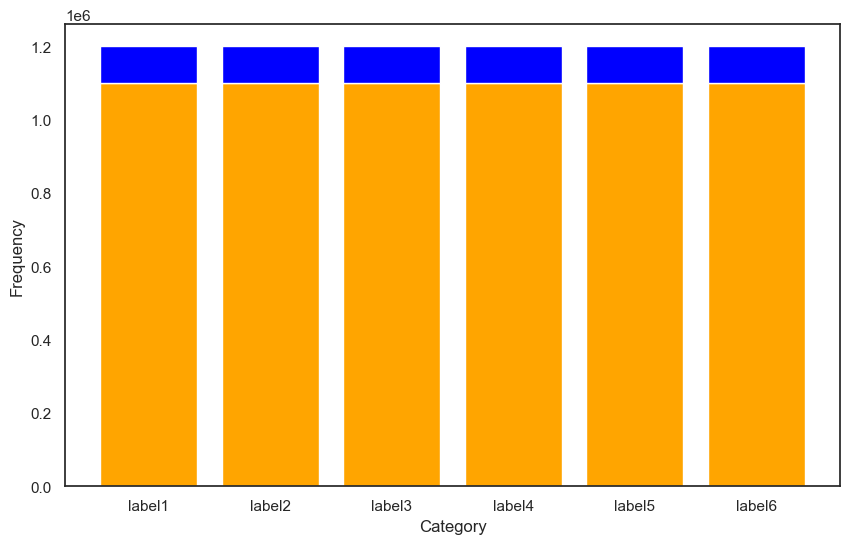

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))

categories = dataframe_generated.drop(dataframe_generated.columns[[6,7,8,9,10,11,12,13]], axis=1)
colors = ['orange', 'blue']

for i, category in enumerate(categories):
    counts = dataframe_generated[category].value_counts()
    ax.bar(category, counts[0], color=colors[0], label='0' if 0 in counts.index else '')
    ax.bar(category, counts[1], color=colors[1], bottom=counts[0], label='1' if 1 in counts.index else '')

ax.set_ylabel('Frequency')
ax.set_xlabel('Category')
#ax.legend(title='Label')

plt.show()

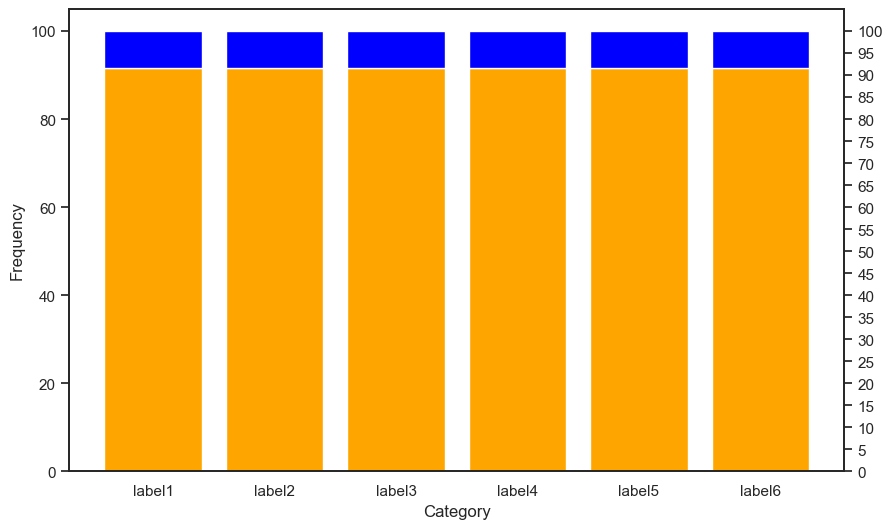

In [31]:
df = pd.DataFrame(data)

# Crear un histograma por cada categoría
fig, ax = plt.subplots(figsize=(10, 6))

categories = dataframe_generated.drop(dataframe_generated.columns[[6,7,8,9,10,11,12,13]], axis=1)
colors = ['orange', 'blue']

for i, category in enumerate(categories):
    total = len(dataframe_generated[category])
    counts = dataframe_generated[category].value_counts(normalize=True) * 100  # Calcula los porcentajes
    ax.bar(category, counts[0], color=colors[0], label='0' if 0 in counts.index else '')
    ax.bar(category, counts[1], color=colors[1], bottom=counts[0], label='1' if 1 in counts.index else '')

ax.set_ylabel('Frequency')
ax.set_xlabel('Category')
#ax.legend(title='Valor')

ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())  # Hacer que los límites del segundo eje coincidan con el primer eje
ax2.set_yticks(range(0, 101, 5))  # Establecer los ticks de la escala secundaria cada 2 unidades

plt.show()

In [32]:
# Definir una lista con los nuevos nombres de las columnas
nuevos_nombres = ['label1', 'label2', 'label3', 'label4', 'label5', 'label6', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'F','t']
# Asignar los nuevos nombres a las columnas
dataframe_generated.columns = nuevos_nombres
# Lista de nombres de las columnas que deseas convertir en enteros
columnas_a_convertir = ['label1', 'label2', 'label3', 'label4', 'label5', 'label6']
# Utiliza el método astype para convertir las columnas en enteros
dataframe_generated[columnas_a_convertir] = dataframe_generated[columnas_a_convertir].astype(int)
dataframe_generated

,label1,label2,label3,label4,label5,label6,d1,d2,d3,d4,d5,d6,F,t
0,0,0,0,0,0,0,0.004081,0.009004,0.013986,0.019010,0.023331,0.027291,290.760154,0.044705
1,0,0,0,0,0,0,0.000589,0.001331,0.002190,0.002852,0.003154,0.003297,30.154762,1.175977
2,0,0,1,0,0,0,0.001895,0.005388,0.009216,0.014015,0.015967,0.017993,161.215506,46.375002
3,0,0,0,0,0,0,0.003157,0.007192,0.011149,0.015354,0.019042,0.022526,252.929137,1.166607
4,0,0,0,0,0,0,0.000243,0.000659,0.000349,0.000545,0.000742,0.000819,12.269107,0.109898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,0,0,0,0,0,1,0.002416,0.007470,0.012884,0.020118,0.024678,0.028994,256.179218,91.677811
1199996,0,0,1,0,0,0,0.001282,0.003639,0.006363,0.010315,0.011163,0.012198,94.296133,52.726634
1199997,0,0,0,0,0,0,0.004170,0.009136,0.014405,0.019810,0.024039,0.028214,299.288494,2.320253
1199998,0,0,0,0,0,1,0.001767,0.006483,0.011977,0.019484,0.023658,0.027638,235.751288,93.435570


In [33]:
#dataframe_generated.to_csv("dataframe_generated_training.csv", index=False)
np.savetxt("X_generated_training " + str(j) + ".csv",dataframe_generated, delimiter=",")

In [34]:
maximos_por_columna = dataframe_generated.max()
maximos_por_columna

label1      1.000000
label2      1.000000
label3      1.000000
label4      1.000000
label5      1.000000
label6      1.000000
d1          0.012667
d2          0.019939
d3          0.026462
d4          0.031769
d5          0.037626
d6          0.043699
F         451.316377
t          98.641255
dtype: float64

In [35]:
media_por_columna = dataframe_generated.mean()
media_por_columna

label1      0.083333
label2      0.083333
label3      0.083333
label4      0.083333
label5      0.083333
label6      0.083333
d1          0.002089
d2          0.004945
d3          0.007792
d4          0.011220
d5          0.013056
d6          0.014904
F         148.019857
t          24.211167
dtype: float64

In [36]:
min_por_columna = dataframe_generated.min()
min_por_columna

label1     0.000000
label2     0.000000
label3     0.000000
label4     0.000000
label5     0.000000
label6     0.000000
d1        -0.001228
d2         0.000130
d3        -0.000366
d4        -0.000029
d5        -0.001126
d6        -0.003087
F        -34.450182
t         -2.645556
dtype: float64

In [37]:
generated_out_final = dataframe_generated.drop(dataframe_generated.columns[[0,1,2,3,4,5]], axis=1)

In [38]:
generated_out_final.shape

(1200000, 8)

In [39]:
generated_out_final=generated_out_final.values

In [40]:
generated_out_final.dtype

dtype('float64')

In [41]:
c=generated_out_final.shape[0]
c

1200000

In [42]:
out=out[0:c,:]

In [43]:
out.shape

(1200000, 8)

In [44]:
out.dtype

dtype('float32')

In [45]:
generated_out_final.shape

(1200000, 8)

In [46]:
generated_out_final.dtype

dtype('float64')

In [47]:
generated_out_final = generated_out_final.astype(np.float32)
generated_out_final.dtype

dtype('float32')

In [48]:
#Metrics: SSIM, SSIM=0 =>totally different , SSIM=0.8 => Duplicates (see reference Guan S et al, Evaluation of GAN performance ..)
# Resize the images to the same dimensions
#dataset_test = np.resize(dataset_test,(239999, 9))

# Calculate the SSIM between the two distributions
ssim_value = ssim(out, generated_out_final, multichannel=True)

print('SSIM:', ssim_value)

C:\Users\mariamegia\AppData\Local\Temp\ipykernel_20020\2595714274.py:6: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(out, generated_out_final, multichannel=True)


SSIM: 0.771417


In [49]:
#Metrics: Wasserstein distance
#sample_data = np.concatenate((t_train, f_train, d1_train, d2_train, d3_train, d4_train, d5_train, d6_train, label_train,), axis=1)
wasserstein_dist = wasserstein_distance(out.ravel(), generated_out_final.ravel())
print("Waserstein distance of the generated dataset:", wasserstein_dist)


Waserstein distance of the generated dataset: 6.641162286704885


In [50]:
#Metrics: FID
real_mean = np.mean(out, axis=0)
real_covariance = np.cov(out, rowvar=False)

fake_mean = np.mean(generated_out_final, axis=0)
fake_covariance = np.cov(generated_out_final, rowvar=False)

mean_difference = real_mean - fake_mean
mean_difference_squared = np.dot(mean_difference, mean_difference)
prod_covariance = real_covariance * fake_covariance

covariance_sqrt, _ = scipy.linalg.sqrtm(prod_covariance, disp=False)
if not np.isfinite(covariance_sqrt).all():
    offset = np.eye(sum_covariance.shape[0]) * 1e-6
    covariance_sqrt = scipy.linalg.sqrtm((prod_covariance + offset), disp=False)
    
fid1 = mean_difference_squared + np.trace(real_covariance + fake_covariance - 2 * covariance_sqrt)
print("Frechet Inception Distance (FID):", fid1)

Frechet Inception Distance (FID): 2674.747746487804


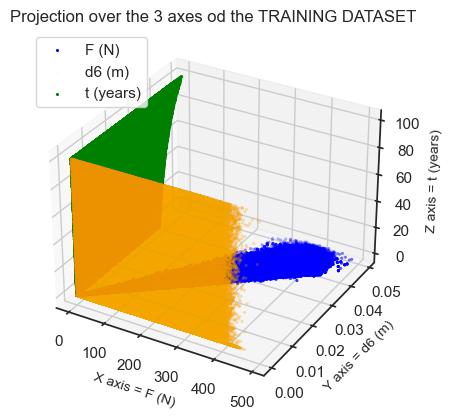

In [51]:
F_train = dataframe['F']
d6_train = dataframe['d6']
t_train = dataframe['t']

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_title("Projection over the 3 axes od the TRAINING DATASET")
#ax.scatter(x_train,y_train,z_train, 'o')
ax.set_xlabel('X axis = F (N)', fontsize='small')
ax.set_ylabel('Y axis = d6 (m)', fontsize='small')
ax.set_zlabel('Z axis = t (years)', fontsize='small')

cx = np.ones_like(F_train) * ax.get_xlim3d()[0]
cy = np.ones_like(d6_train) * ax.get_ylim3d()[0]
cz = np.ones_like(t_train) * ax.get_zlim3d()[0]

ax.scatter(F_train,  d6_train,  cz,               marker='.', lw=0,  color = "blue" , label= "F (N)")
ax.scatter(F_train,  cy,       t_train,        marker='.', lw=0, alpha=0.05 , color ="orange", label = "d6 (m)")
ax.scatter(cx,       d6_train,  t_train,         marker='.', lw=0,  color ="green", label ="t (years)")

ax.set_xlim3d(ax.get_xlim3d())
ax.set_ylim3d(ax.get_ylim3d())
ax.set_zlim3d(ax.get_zlim3d())
ax.set_xlabel('X axis = F (N)')
ax.set_ylabel('Y axis = d6 (m)')
ax.set_zlabel('Z axis = t (years)')
ax.legend(loc='upper left')
plt.show()

# F es la variable independiente
# d6 es la variable dependiente
# t influye en el parámetro k; F = K(t) * d6


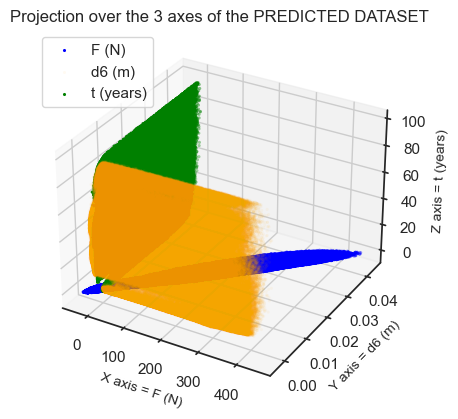

In [52]:
F_predicted = dataframe_generated['F']
d6_predicted = dataframe_generated['d6']
t_predicted = dataframe_generated['t']

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_title("Projection over the 3 axes of the PREDICTED DATASET")
#ax.scatter(x_train,y_train,z_train, 'o')
ax.set_xlabel('X axis = F (N)', fontsize='small')
ax.set_ylabel('Y axis = d6 (m)', fontsize='small')
ax.set_zlabel('Z axis = t (years)', fontsize='small')

cx = np.ones_like(F_predicted) * ax.get_xlim3d()[0]
cy = np.ones_like(d6_predicted) * ax.get_ylim3d()[0]
cz = np.ones_like(t_predicted) * ax.get_zlim3d()[0]

ax.scatter(F_predicted,  d6_predicted,  cz,               marker='.', lw=0,  color = "blue" , label= "F (N)")
ax.scatter(F_predicted,  cy,       t_predicted,        marker='.', lw=0, alpha=0.05 , color ="orange", label = "d6 (m)")
ax.scatter(cx,       d6_predicted,  t_predicted,         marker='.', lw=0,  color ="green", label ="t (years)")

ax.set_xlim3d(ax.get_xlim3d())
ax.set_ylim3d(ax.get_ylim3d())
ax.set_zlim3d(ax.get_zlim3d())
ax.set_xlabel('X axis = F (N)')
ax.set_ylabel('Y axis = d6 (m)')
ax.set_zlabel('Z axis = t (years)')
ax.legend(loc='upper left')
plt.show()

# F es la variable independiente
# d6 es la variable dependiente
# t influye en el parámetro k; F = K(t) * d6


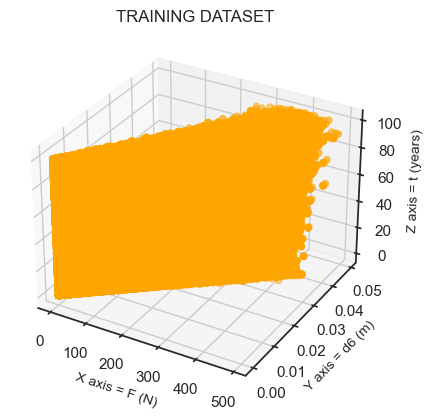

In [53]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_title("TRAINING DATASET")
ax.scatter(F_train,d6_train,t_train, 'o', color = 'orange')
ax.set_xlabel('X axis = F (N)', fontsize='small')
ax.set_ylabel('Y axis = d6 (m)', fontsize='small')
ax.set_zlabel('Z axis = t (years)', fontsize='small')
plt.show()

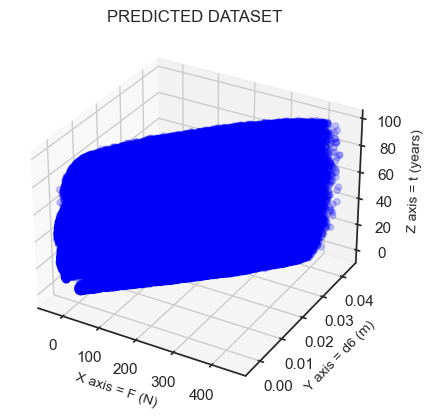

In [54]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_title("PREDICTED DATASET")
ax.scatter(F_predicted,d6_predicted,t_predicted, 'o', color = 'blue', alpha=0.2)
ax.set_xlabel('X axis = F (N)', fontsize='small')
ax.set_ylabel('Y axis = d6 (m)', fontsize='small')
ax.set_zlabel('Z axis = t (years)', fontsize='small')
plt.show()

## Testing

#### Dataset de test

In [55]:
dataTest= pd.read_excel('dataTest_shuffled_label.xlsx', header=None)
#dataTest=pd.read_csv('dataTest_shuffled.csv', header=None, sep=';')
dataTest

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,0,0,0,1,0,1,0.005,0.009,0.014,0.019,0.030,0.035,292.485088,100
1,0,0,0,1,0,0,1,0.002,0.004,0.006,0.009,0.011,0.012,104.436150,66
2,0,0,0,0,0,0,0,0.005,0.011,0.017,0.022,0.028,0.034,354.603868,0
3,0,0,0,0,0,0,0,0.003,0.005,0.008,0.011,0.014,0.017,184.749157,0
4,0,0,1,0,0,0,1,0.005,0.009,0.021,0.025,0.030,0.035,325.116362,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1831,0,0,0,0,0,0,0,0.003,0.007,0.010,0.013,0.017,0.020,236.672468,0
1832,0,0,0,0,0,0,0,0.000,0.000,0.001,0.001,0.001,0.001,12.716305,0
1833,0,0,0,0,0,0,0,0.005,0.010,0.015,0.020,0.025,0.030,317.570163,0
1834,0,1,0,0,0,0,1,0.006,0.016,0.022,0.028,0.034,0.040,420.919111,66


In [56]:
num_test=dataTest.shape[0]
num_test

1836

In [57]:
out_test = dataTest.drop(dataTest.columns[:7], axis=1)
out_test

,7,8,9,10,11,12,13,14
0,0.005,0.009,0.014,0.019,0.030,0.035,292.485088,100
1,0.002,0.004,0.006,0.009,0.011,0.012,104.436150,66
2,0.005,0.011,0.017,0.022,0.028,0.034,354.603868,0
3,0.003,0.005,0.008,0.011,0.014,0.017,184.749157,0
4,0.005,0.009,0.021,0.025,0.030,0.035,325.116362,100
...,...,...,...,...,...,...,...,...
1831,0.003,0.007,0.010,0.013,0.017,0.020,236.672468,0
1832,0.000,0.000,0.001,0.001,0.001,0.001,12.716305,0
1833,0.005,0.010,0.015,0.020,0.025,0.030,317.570163,0
1834,0.006,0.016,0.022,0.028,0.034,0.040,420.919111,66


In [58]:
condition_test = dataTest.drop(dataTest.columns[6:], axis=1)
condition_test

,0,1,2,3,4,5
0,0,0,0,0,1,0
1,0,0,0,1,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,1,0,0,0
...,...,...,...,...,...,...
1831,0,0,0,0,0,0
1832,0,0,0,0,0,0
1833,0,0,0,0,0,0
1834,0,1,0,0,0,0


In [59]:
condition_test = condition_test.to_numpy()

In [60]:
noise = tf.random.normal([num_test, noise_dim], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32)

In [61]:
test_generated_out = generator([condition_test, noise], training=False)

In [62]:
test_generated_out

<tf.Tensor: shape=(1836, 8), dtype=float32, numpy=
array([[-0.00686585,  0.04210075,  0.03318305, ..., -0.0141893 ,
        -0.03323378,  0.539132  ],
       [ 0.3286979 ,  0.4837449 ,  0.56630415, ...,  0.6812118 ,
         0.65764934,  0.7095461 ],
       [ 0.24615975,  0.36741313,  0.4362972 , ...,  0.475002  ,
         0.506771  ,  0.00928149],
       ...,
       [ 0.19211076,  0.3013793 ,  0.36252102, ...,  0.3934306 ,
         0.4452727 , -0.00282746],
       [ 0.1289975 ,  0.24524905,  0.30603027, ...,  0.3550573 ,
         0.32690692,  0.3489802 ],
       [ 0.18917431,  0.32737127,  0.41231477, ...,  0.51164144,
         0.46875566,  0.6570085 ]], dtype=float32)>

In [63]:
a=test_generated_out.shape[0]
a

1836

In [64]:
test_generated_out_final = scaler.inverse_transform(test_generated_out)
test_generated_out_final

array([[-1.02954632e-04,  9.17639011e-04,  9.50252691e-04, ...,
        -6.96026203e-04, -1.64401441e+01,  5.39132011e+01],
       [ 4.92888923e-03,  1.05438291e-02,  1.62170723e-02, ...,
         3.34154450e-02,  3.25327233e+02,  7.09546105e+01],
       [ 3.69121364e-03,  8.00823200e-03,  1.24941049e-02, ...,
         2.33002457e-02,  2.50690463e+02,  9.28148648e-01],
       ...,
       [ 2.88073853e-03,  6.56894131e-03,  1.03813997e-02, ...,
         1.92989285e-02,  2.20268360e+02, -2.82745791e-01],
       [ 1.93434289e-03,  5.34551194e-03,  8.76369201e-03, ...,
         1.74166057e-02,  1.61714943e+02,  3.48980196e+01],
       [ 2.83670585e-03,  7.13546916e-03,  1.18073275e-02, ...,
         2.50975186e-02,  2.31884949e+02,  6.57008543e+01]])

In [65]:
plot_data_generated = np.concatenate([condition_test, test_generated_out_final], axis=1)

In [66]:
plot_data_generated.shape

(1836, 14)

In [67]:
df_data_generated=pd.DataFrame(plot_data_generated)
df_data_generated

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.0,0.0,0.0,0.0,1.0,0.0,-0.000103,0.000918,0.000950,0.002741,0.000834,-0.000696,-16.440144,53.913201
1,0.0,0.0,0.0,1.0,0.0,0.0,0.004929,0.010544,0.016217,0.022674,0.028197,0.033415,325.327233,70.954611
2,0.0,0.0,0.0,0.0,0.0,0.0,0.003691,0.008008,0.012494,0.016348,0.019879,0.023300,250.690463,0.928149
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000261,0.000838,0.001504,0.002515,0.002930,0.003299,33.019207,0.338000
4,0.0,0.0,1.0,0.0,0.0,0.0,0.002578,0.006329,0.010310,0.015029,0.017488,0.020051,192.124987,33.499012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1831,0.0,0.0,0.0,0.0,0.0,0.0,0.001807,0.004389,0.007030,0.009610,0.011110,0.012599,136.523922,0.456939
1832,0.0,0.0,0.0,0.0,0.0,0.0,0.003511,0.007975,0.012383,0.017233,0.021302,0.025250,277.820631,1.519877
1833,0.0,0.0,0.0,0.0,0.0,0.0,0.002881,0.006569,0.010381,0.013853,0.016683,0.019299,220.268360,-0.282746
1834,0.0,1.0,0.0,0.0,0.0,0.0,0.001934,0.005346,0.008764,0.013440,0.015380,0.017417,161.714943,34.898020


In [68]:
filtro = (df_data_generated.iloc[:, 7] >= 0) & (df_data_generated.iloc[:, 8] >= 0) & (df_data_generated.iloc[:, 9] >= 0) & (df_data_generated.iloc[:, 10] >= 0) & (df_data_generated.iloc[:, 11] >= 0) & (df_data_generated.iloc[:, 12] >= 0) & (df_data_generated.iloc[:, 13] >= 0) & (df_data_generated.iloc[:, 14] >= 0)
df_data_generated_filtrado = df_data_generated[filtro]
b=df_data_generated_filtrado.shape[0]
b

IndexError: single positional indexer is out-of-bounds

In [69]:
(a-b)*100/a

NameError: name 'b' is not defined

In [71]:
data_generated_filtrado = df_data_generated_filtrado.values

In [72]:
data_generated_filtrado.shape

(1573, 15)

In [73]:
plot_data_real = dataTest
plot_data_real.shape

(1836, 15)

In [74]:
plot_data_real.shape
plot_data_real = dataTest

In [75]:
plot_data_real.shape

(1836, 15)

In [76]:
plot_data_generated.shape

(1836, 15)

C:\Users\mariamegia\AppData\Local\Temp\ipykernel_14004\3112405342.py:71: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


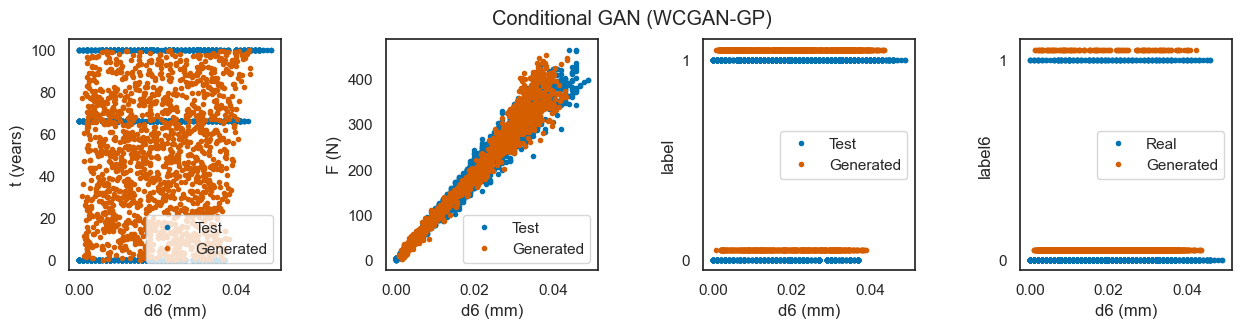

In [77]:
plot_data_generated = data_generated_filtrado

#list_limx = [[0, .050], [0, .050], [0, .050], [0, .050]]
#list_limy = [[0, 100], [0, 450], [-0.1, 1.1], [-0.1, 1.1]]
figure, ax = plt.subplots(1, 4, figsize=(15, 3))
figure.suptitle("Conditional GAN (WCGAN-GP)")
sns.set(color_codes=True, style='white', palette='colorblind')
          
### d6 - t  ###
i = 0
ax[i].clear()
#ax[i].set_xlim(list_limx[i])
#ax[i].set_ylim(list_limy[i])
ax[i].set_xlabel('d6 (mm)')
ax[i].set_ylabel('t (years)')
plot_data_real = dataTest
#plot_data_real = dataTest[:, :]                      
ax[i].plot(plot_data_real[ 12], plot_data_real[ 14], '.b', alpha=1, label="Test")
ax[i].plot(plot_data_generated[:num_test, 12], plot_data_generated[:num_test, 14], '.r', alpha=1, label="Generated")
ax[i].legend(loc='lower right')  #ojo
                                  
            
###  d6 - F  ###
i = 1
ax[i].clear()
#ax[i].set_xlim(list_limx[i])
#ax[i].set_ylim(list_limy[i])
ax[i].set_xlabel('d6 (mm)')
ax[i].set_ylabel('F (N)')
ax[i].plot(plot_data_real [ 12], plot_data_real [ 13], '.b', alpha=1, label="Test")
ax[i].plot(plot_data_generated[:num_test, 12], plot_data_generated[:num_test, 13], '.r', alpha=1, label="Generated")
ax[i].legend(loc='lower right')
            
### d6 - label ###
i = 2
ax[i].clear()
#ax[i].set_xlim(list_limx[i])
#ax[i].set_ylim(list_limy[i])
ax[i].set_xlabel('d6 (mm)')
ax[i].set_ylabel('label')
ax[i].plot(plot_data_real [ 12], plot_data_real [ 6], '.b', alpha=1, label="Test")
ax[i].yaxis.set_major_locator(plt.MultipleLocator(base=1)) #ojo
ax[i].yaxis.set_major_formatter('{:.0f}'.format)  #ojo
ax[i].plot(plot_data_generated[:num_test, 12], plot_data_generated[:num_test, 6]+0.05, '.r', alpha=1, label="Generated")
ax[i].legend(loc='center right')


### d6  -  label6  ###
i = 3
ax[i].clear()
#ax[i].set_xlim(list_limx[i])
#ax[i].set_ylim(list_limy[i])
ax[i].set_xlabel('d6 (mm)')
ax[i].set_ylabel('label6')
ax[i].plot(plot_data_real[ 12], plot_data_real[ 5], '.b', alpha=1, label="Real")
ax[i].yaxis.set_major_locator(plt.MultipleLocator(base=1)) #ojo
ax[i].yaxis.set_major_formatter('{:.0f}'.format)  #ojo
ax[i].plot(plot_data_generated[:num_test, 12], plot_data_generated[:num_test, 5]+0.05, '.r', alpha=1, label="Generated")
ax[i].legend(loc='center right')
plt.subplots_adjust(wspace=0.5)  #ojo    

### Figure Loss-Epochs ###
#i = 4
#ax[i].clear() 
#ax[i].plot([-i for i in loss_G_train], '-', label="Gen loss")        #ojo
#ax[i].plot([-i for i in loss_D_train], '-', label="Crit loss")   #ojo
#ax[i].set_title('Loss')
#ax[i].set_xlabel('Epoch')
#ax[i].legend()  #ojo

figure.show()


In [78]:
test_generated_out_final = plot_data_generated [:,7:15]
test_generated_out_final.shape

(1573, 8)

In [79]:
b

1573

In [80]:
out_test.shape

(1836, 8)

In [81]:
out_test

,7,8,9,10,11,12,13,14
0,0.005,0.009,0.014,0.019,0.030,0.035,292.485088,100
1,0.002,0.004,0.006,0.009,0.011,0.012,104.436150,66
2,0.005,0.011,0.017,0.022,0.028,0.034,354.603868,0
3,0.003,0.005,0.008,0.011,0.014,0.017,184.749157,0
4,0.005,0.009,0.021,0.025,0.030,0.035,325.116362,100
...,...,...,...,...,...,...,...,...
1831,0.003,0.007,0.010,0.013,0.017,0.020,236.672468,0
1832,0.000,0.000,0.001,0.001,0.001,0.001,12.716305,0
1833,0.005,0.010,0.015,0.020,0.025,0.030,317.570163,0
1834,0.006,0.016,0.022,0.028,0.034,0.040,420.919111,66


In [82]:
b

1573

In [83]:
oo=out_test.iloc[0:b, :]
out_test = oo
out_test.shape

(1573, 8)

In [84]:
out_test=out_test.values

In [85]:
#Metrics: Wasserstein distance
#sample_data = np.concatenate((t_train, f_train, d1_train, d2_train, d3_train, d4_train, d5_train, d6_train, label_train,), axis=1)
wasserstein_dist = wasserstein_distance(out_test.ravel(), test_generated_out_final.ravel())
print("Waserstein distance of the generated dataset:", wasserstein_dist)


Waserstein distance of the generated dataset: 2.510404441460112


In [86]:
#Metrics: FID
real_mean = np.mean(out_test, axis=0)
real_covariance = np.cov(out_test, rowvar=False)

fake_mean = np.mean(test_generated_out_final, axis=0)
fake_covariance = np.cov(test_generated_out_final, rowvar=False)

mean_difference = real_mean - fake_mean
mean_difference_squared = np.dot(mean_difference, mean_difference)
prod_covariance = real_covariance * fake_covariance

covariance_sqrt, _ = scipy.linalg.sqrtm(prod_covariance, disp=False)
if not np.isfinite(covariance_sqrt).all():
    offset = np.eye(sum_covariance.shape[0]) * 1e-6
    covariance_sqrt = scipy.linalg.sqrtm((prod_covariance + offset), disp=False)
    
fid1 = mean_difference_squared + np.trace(real_covariance + fake_covariance - 2 * covariance_sqrt)
print("Frechet Inception Distance (FID):", fid1)

Frechet Inception Distance (FID): 219.58039065173963


In [87]:
test_generated_out_final.dtype

dtype('float64')

In [88]:
dataTest=dataTest.to_numpy()

In [89]:

#Metrics: SSIM, SSIM=0 =>totally different , SSIM=0.8 => Duplicates (see reference Guan S et al, Evaluation of GAN performance ..)
# Resize the images to the same dimensions
#dataset_test = np.resize(dataset_test,(239999, 9))

# Calculate the SSIM between the two distributions
ssim_value = ssim(out_test, test_generated_out_final, multichannel=True)

print('SSIM:', ssim_value)

SSIM: 0.711656953487098


C:\Users\mariamegia\AppData\Local\Temp\ipykernel_14004\778844230.py:6: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(out_test, test_generated_out_final, multichannel=True)


In [90]:
dataTest=pd.DataFrame(dataTest)
dataTest

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.005,0.009,0.014,0.019,0.030,0.035,292.485088,100.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.002,0.004,0.006,0.009,0.011,0.012,104.436150,66.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005,0.011,0.017,0.022,0.028,0.034,354.603868,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003,0.005,0.008,0.011,0.014,0.017,184.749157,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.005,0.009,0.021,0.025,0.030,0.035,325.116362,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1831,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003,0.007,0.010,0.013,0.017,0.020,236.672468,0.0
1832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.001,0.001,0.001,0.001,12.716305,0.0
1833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005,0.010,0.015,0.020,0.025,0.030,317.570163,0.0
1834,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.006,0.016,0.022,0.028,0.034,0.040,420.919111,66.0


In [91]:
df_data_generated_filtrado

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.001762,0.003509,0.004593,0.007599,0.011510,0.013912,140.825573,75.518961
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.005026,0.010168,0.014269,0.020389,0.026856,0.032253,327.273353,25.803841
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001185,0.002314,0.004131,0.005698,0.007225,0.008563,87.542499,25.964276
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.001653,0.004065,0.007263,0.010966,0.013182,0.015491,123.979185,98.932894
5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.001262,0.002044,0.002977,0.004563,0.006239,0.007456,72.479823,64.481862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1831,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004313,0.008916,0.014385,0.018709,0.023130,0.027768,263.692756,40.413184
1832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004764,0.010202,0.016046,0.020705,0.025988,0.031003,311.489385,46.403233
1833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004059,0.009137,0.015353,0.020863,0.026048,0.030747,275.386381,62.839462
1834,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.001676,0.003534,0.004776,0.007595,0.011550,0.013807,123.715205,87.228252


<Figure size 640x480 with 0 Axes>

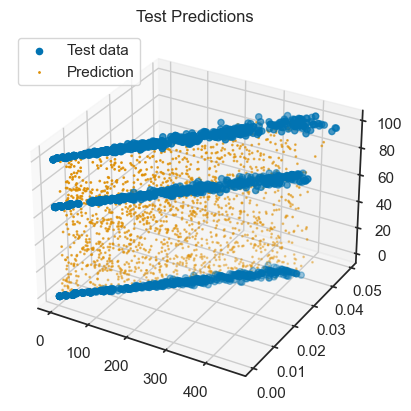

In [92]:
test_generated_out_final_df=df_data_generated_filtrado

F_test = dataTest[13]
d6_test = dataTest[12]
t_test = dataTest[14]

F_predicted = test_generated_out_final_df[13]
d6_predicted = test_generated_out_final_df[12]
t_predicted = test_generated_out_final_df[14]

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(F_test, d6_test, t_test, label="Test data")
ax.scatter(F_predicted, d6_predicted, t_predicted, label="Prediction", s=1)

ax.set_title("Test Predictions")
ax.legend(loc='upper left')

texto1= "Wasserstein distance of the Predicted Test: " + str(wasserstein_dist)
ax.text(-35, 37, 10, texto1, fontsize=8)  #0.25 F, -35 N
texto2="Frechet Inception Distance (FID) of the Test: " #+ str(fid)
ax.text(-35, 35, 10, texto2, fontsize=8)
figure = ax.get_figure()   
figure.savefig("predictions_test" + '_' + str(j) + '_' ".png")
plt.show()

np.savetxt("X_generated_test " + str(j) + ".csv", test_generated_out_final_df, delimiter=",")

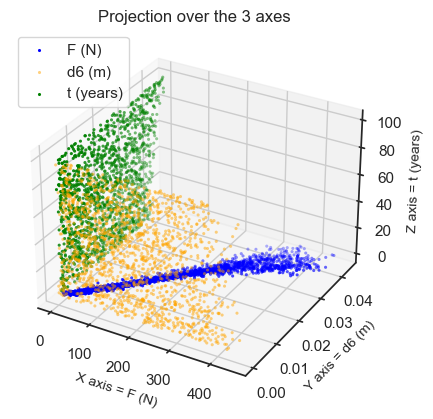

In [93]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_title("Projection over the 3 axes")
#ax.scatter(x_train,y_train,z_train, 'o')
ax.set_xlabel('X axis = F (N)', fontsize='small')
ax.set_ylabel('Y axis = d6 (m)', fontsize='small')
ax.set_zlabel('Z axis = t (years)', fontsize='small')

cx = np.ones_like(F_predicted) * ax.get_xlim3d()[0]
cy = np.ones_like(d6_predicted) * ax.get_ylim3d()[0]
cz = np.ones_like(t_predicted) * ax.get_zlim3d()[0]

ax.scatter(F_predicted,  d6_predicted,  cz,               marker='.', lw=0,  color = "blue" , label= "F (N)")
ax.scatter(F_predicted,  cy,       t_predicted,        marker='.', lw=0, alpha=0.5 , color ="orange", label = "d6 (m)")
ax.scatter(cx,       d6_predicted,  t_predicted,         marker='.', lw=0,  color ="green", label ="t (years)")

ax.set_xlim3d(ax.get_xlim3d())
ax.set_ylim3d(ax.get_ylim3d())
ax.set_zlim3d(ax.get_zlim3d())
ax.set_xlabel('X axis = F (N)')
ax.set_ylabel('Y axis = d6 (m)')
ax.set_zlabel('Z axis = t (years)')
ax.legend(loc='upper left')
plt.show()

# F es la variable independiente
# d6 es la variable dependiente
# t influye en el parámetro k; F = K(t) * d6

In [94]:
dataset1 = pd.read_excel("datos_sensor.xlsx")
dataset1.head()

,F_real_healthy,D6_real_healthy,F_simulated_healthy,D6_simulated_healthy,F_medium,D6_medium,F_full,D6_full
0,164.555884,13.0,170.58,16.0,125.24,14.0,104.89,15
1,0.000000,0.0,50.52,5.0,151.17,17.0,155.15,24
2,173.785884,16.0,118.65,11.0,120.94,14.0,98.31,14
3,81.678784,6.0,40.41,4.0,89.07,10.0,131.42,20
4,268.722584,23.0,27.96,3.0,141.22,16.0,136.52,20


In [95]:
dataset1 = dataset1.values

x_healthy= dataset1[:,0] 
y_healthy= dataset1[:,1]
x_medium= dataset1[:,4] 
y_medium= dataset1[:,5]
x_full= dataset1[:,6] 
y_full= dataset1[:,7]

In [96]:
dfG = test_generated_out_final_df
dfG

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.001762,0.003509,0.004593,0.007599,0.011510,0.013912,140.825573,75.518961
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.005026,0.010168,0.014269,0.020389,0.026856,0.032253,327.273353,25.803841
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001185,0.002314,0.004131,0.005698,0.007225,0.008563,87.542499,25.964276
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.001653,0.004065,0.007263,0.010966,0.013182,0.015491,123.979185,98.932894
5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.001262,0.002044,0.002977,0.004563,0.006239,0.007456,72.479823,64.481862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1831,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004313,0.008916,0.014385,0.018709,0.023130,0.027768,263.692756,40.413184
1832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004764,0.010202,0.016046,0.020705,0.025988,0.031003,311.489385,46.403233
1833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004059,0.009137,0.015353,0.020863,0.026048,0.030747,275.386381,62.839462
1834,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.001676,0.003534,0.004776,0.007595,0.011550,0.013807,123.715205,87.228252


In [97]:
dfG = dfG.sort_values(by=dfG.columns[-1], axis=0, ascending=True)
dfG

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1805,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.002158,0.005048,0.007386,0.010372,0.012971,0.015695,152.813548,0.031181
1565,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.003852,0.008191,0.011950,0.016500,0.020226,0.024256,242.408498,0.041713
72,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.000681,0.001421,0.001876,0.003231,0.005281,0.006242,46.941343,0.099195
519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002743,0.006303,0.008489,0.013146,0.018081,0.022722,217.761898,0.107904
582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006670,0.011774,0.014784,0.020161,0.024648,0.031354,373.124824,0.200589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.003294,0.007276,0.015565,0.023965,0.031542,0.036620,263.702663,99.303778
866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004642,0.011977,0.021341,0.026990,0.030731,0.035960,310.939754,99.309590
1015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001317,0.002504,0.005718,0.007925,0.009115,0.012023,89.685472,99.383327
201,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.002198,0.005291,0.009994,0.015498,0.019769,0.023251,185.624825,99.719050


In [98]:
filtro = (dfG.iloc[:, -1] >= 0) & (dfG.iloc[:, -1] < 5)
resultado0 = dfG[filtro]
resultado0

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1805,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.002158,0.005048,0.007386,0.010372,0.012971,0.015695,152.813548,0.031181
1565,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.003852,0.008191,0.011950,0.016500,0.020226,0.024256,242.408498,0.041713
72,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.000681,0.001421,0.001876,0.003231,0.005281,0.006242,46.941343,0.099195
519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002743,0.006303,0.008489,0.013146,0.018081,0.022722,217.761898,0.107904
582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006670,0.011774,0.014784,0.020161,0.024648,0.031354,373.124824,0.200589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1713,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.004301,0.008184,0.012904,0.016933,0.020596,0.024723,231.650744,4.469703
1151,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.003019,0.005858,0.008604,0.011908,0.015430,0.018583,198.093008,4.677529
64,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.003556,0.007184,0.010492,0.014202,0.018106,0.021952,228.069297,4.869595
1625,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.000795,0.001677,0.002153,0.003509,0.005144,0.006135,56.255801,4.985263


In [99]:
filtro = (dfG.iloc[:, -1] >= 60) & (dfG.iloc[:, -1] < 70)
resultado66 = dfG[filtro]
resultado66

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
321,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004243,0.007854,0.013621,0.018442,0.023736,0.028085,255.933676,60.171921
444,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.000140,0.000382,0.000216,0.000794,0.001032,0.001244,22.703575,60.202612
1368,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.002840,0.005970,0.008934,0.012372,0.017002,0.020207,191.255630,60.205234
449,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.001782,0.003019,0.004304,0.006971,0.010832,0.012754,107.892582,60.237302
559,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002521,0.004951,0.008936,0.011937,0.015766,0.018819,177.655516,60.254373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004388,0.010249,0.016937,0.022200,0.026852,0.031679,290.562338,69.785614
152,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.001102,0.001999,0.002304,0.004277,0.006864,0.008091,87.540177,69.799270
1415,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.002367,0.005164,0.008315,0.011930,0.017947,0.021480,198.817559,69.799931
1282,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.001598,0.002920,0.003663,0.005880,0.008833,0.010673,101.936682,69.801755


In [100]:
filtro = (dfG.iloc[:, -1] > 90) & (dfG.iloc[:, -1] <= 100)
resultado100 = dfG[filtro]
resultado100

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
725,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005673,0.013708,0.022458,0.027190,0.032261,0.038001,352.294695,90.111222
590,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.001223,0.002055,0.003092,0.005213,0.008353,0.010000,88.734417,90.167590
1377,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.003226,0.006267,0.010997,0.016048,0.022703,0.026757,215.399658,90.203746
770,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.002154,0.004521,0.007584,0.010376,0.015134,0.017941,148.216769,90.584983
272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000814,0.000708,0.002409,0.004329,0.006679,0.007901,65.500792,90.626802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.003294,0.007276,0.015565,0.023965,0.031542,0.036620,263.702663,99.303778
866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004642,0.011977,0.021341,0.026990,0.030731,0.035960,310.939754,99.309590
1015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001317,0.002504,0.005718,0.007925,0.009115,0.012023,89.685472,99.383327
201,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.002198,0.005291,0.009994,0.015498,0.019769,0.023251,185.624825,99.719050


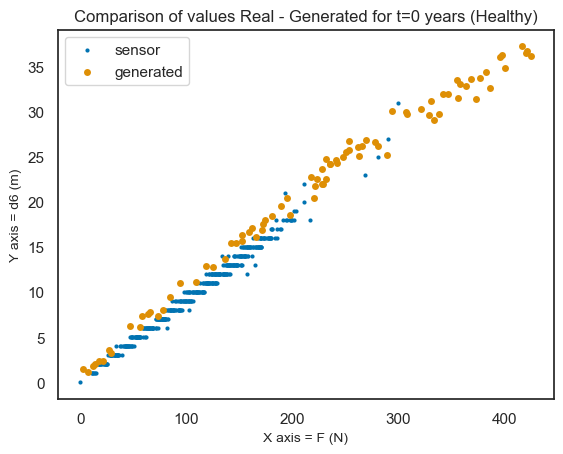

In [101]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Comparison of values Real - Generated for t=0 years (Healthy)")

ax.set_xlabel('X axis = F (N)', fontsize='small')
ax.set_ylabel('Y axis = d6 (m)', fontsize='small')

ax.scatter(x_healthy,  y_healthy,        marker='.', lw=0 , label="sensor")
ax.scatter(resultado0[13],  resultado0[12]*1000,        marker='.', lw=0 , label="generated",s=100)

ax.set_xlabel('X axis = F (N)')
ax.set_ylabel('Y axis = d6 (m)')

ax.legend(loc='upper left')
plt.show()

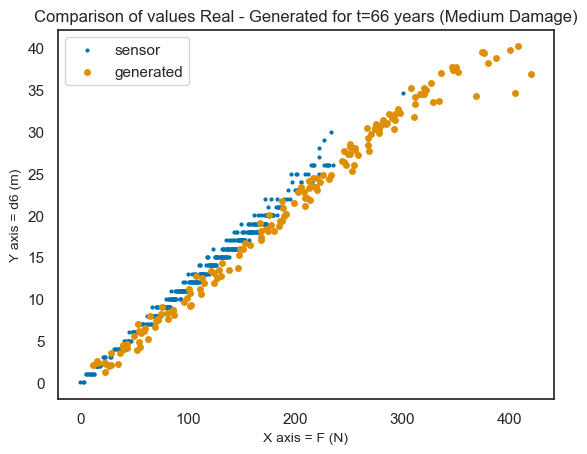

In [102]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Comparison of values Real - Generated for t=66 years (Medium Damage)")

ax.set_xlabel('X axis = F (N)', fontsize='small')
ax.set_ylabel('Y axis = d6 (m)', fontsize='small')


ax.scatter(x_medium,  y_medium,        marker='.', lw=0 , label="sensor")
ax.scatter(resultado66[13],  resultado66[12]*1000,        marker='.', lw=0 , label="generated", s=100)


ax.set_xlabel('X axis = F (N)')
ax.set_ylabel('Y axis = d6 (m)')

ax.legend(loc='upper left')
plt.show()

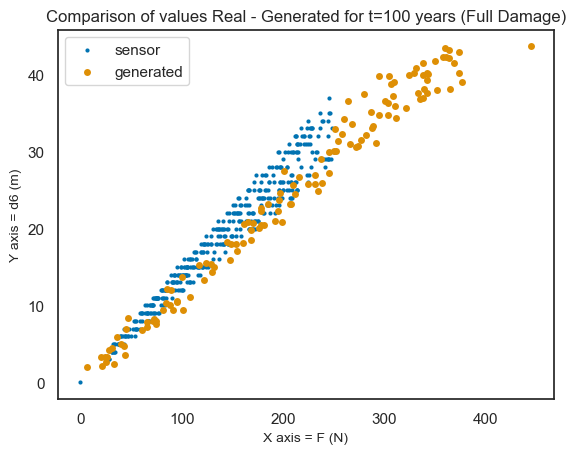

In [103]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Comparison of values Real - Generated for t=100 years (Full Damage)")

ax.set_xlabel('X axis = F (N)', fontsize='small')
ax.set_ylabel('Y axis = d6 (m)', fontsize='small')

ax.scatter(x_full,  y_full,        marker='.', lw=0 , label="sensor")
ax.scatter(resultado100[13],  resultado100[12]*1000,        marker='.', lw=0 , label="generated",s=100)

ax.set_xlabel('X axis = F (N)')
ax.set_ylabel('Y axis = d6 (m)')

ax.legend(loc='upper left')
plt.show()
